# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import torchvision.models as models

from utils import *
from explanations import RISE


In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision as tvis
import time

from utils import *
from explanations import RISE
cudnn.benchmark = True

### Load the dataset

In [2]:
input_size = (224, 224)
batch_size = 16
feature_extract=True

In [3]:
transform = {
        'train': transforms.Compose(
            [   
                transforms.Resize([230, 230]),
                transforms.RandomAffine(degrees=[-60, 60], ),
                transforms.RandomCrop(input_size[0]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, 
                                                   contrast=0.2, 
                                                   saturation=0.2, 
                                                   hue=0.1),
                
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
        }

target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x, dtype=torch.int64), 2)

In [5]:
data_folder = "/home/guest/mabdelfa/zerowaste/data/zerowaste-w/"
dataset = datasets.ImageFolder(root = data_folder, transform=transform['train'],
                              target_transform=target_transform)
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [6]:
print(dataset.class_to_idx)

{'after': 0, 'before': 1}


In [7]:
img, labels = next(iter(validation_loader))

"""
for i in range(5):
    print(labels[i])
    plt.imshow(img[i].permute((1, 2, 0)))
    plt.show()
"""

'\nfor i in range(5):\n    print(labels[i])\n    plt.imshow(img[i].permute((1, 2, 0)))\n    plt.show()\n'

### Define the model

In [8]:
model = models.resnet50(True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = nn.Sequential(model, nn.Softmax())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [9]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_ft, gamma=0.9)

Params to learn:
	 0.conv1.weight
	 0.bn1.weight
	 0.bn1.bias
	 0.layer1.0.conv1.weight
	 0.layer1.0.bn1.weight
	 0.layer1.0.bn1.bias
	 0.layer1.0.conv2.weight
	 0.layer1.0.bn2.weight
	 0.layer1.0.bn2.bias
	 0.layer1.0.conv3.weight
	 0.layer1.0.bn3.weight
	 0.layer1.0.bn3.bias
	 0.layer1.0.downsample.0.weight
	 0.layer1.0.downsample.1.weight
	 0.layer1.0.downsample.1.bias
	 0.layer1.1.conv1.weight
	 0.layer1.1.bn1.weight
	 0.layer1.1.bn1.bias
	 0.layer1.1.conv2.weight
	 0.layer1.1.bn2.weight
	 0.layer1.1.bn2.bias
	 0.layer1.1.conv3.weight
	 0.layer1.1.bn3.weight
	 0.layer1.1.bn3.bias
	 0.layer1.2.conv1.weight
	 0.layer1.2.bn1.weight
	 0.layer1.2.bn1.bias
	 0.layer1.2.conv2.weight
	 0.layer1.2.bn2.weight
	 0.layer1.2.bn2.bias
	 0.layer1.2.conv3.weight
	 0.layer1.2.bn3.weight
	 0.layer1.2.bn3.bias
	 0.layer2.0.conv1.weight
	 0.layer2.0.bn1.weight
	 0.layer2.0.bn1.bias
	 0.layer2.0.conv2.weight
	 0.layer2.0.bn2.weight
	 0.layer2.0.bn2.bias
	 0.layer2.0.conv3.weight
	 0.layer2.0.bn3.weight

In [10]:
criterion = torch.nn.BCELoss()
dataloaders_dict = {"train": train_loader, "val": validation_loader}

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 1.

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_samples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.to(torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    labels.data = labels.data
                    loss = criterion(outputs, labels.data)
                    preds = (outputs > 0.5).type(torch.cuda.FloatTensor)
                   
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.mean(torch.abs(preds - labels.data))
                num_samples += 1

            epoch_loss = running_loss / batch_size * num_samples
            epoch_acc = running_corrects.double() / num_samples

            print('{} Loss: {:.4f} MSE: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            
            #scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MSE: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
train_from_scratch = False
ckpt_path = "binary_classifier_2.pt"

if train_from_scratch:
    model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=4)
    torch.save(model_ft.state_dict(), ckpt_path)
else:
    model.load_state_dict(torch.load(ckpt_path))

Epoch 0/3
----------
/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
train Loss: 3028.8153 MSE: 0.0801
val Loss: 116.5463 MSE: 0.0383

Epoch 1/3
----------
train Loss: 1771.8468 MSE: 0.0434
val Loss: 117.5008 MSE: 0.0484

Epoch 2/3
----------
train Loss: 1194.3428 MSE: 0.0305
val Loss: 42.4766 MSE: 0.0141

Epoch 3/3
----------
train Loss: 936.3347 MSE: 0.0253
val Loss: 62.9043 MSE: 0.0262

Training complete in 9m 18s
Best val MSE: 0.014113


In [13]:
for p in model.parameters():
    p.requires_grad = False
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [14]:

for img, labels in dataloaders_dict["val"]:
    img = img.to(device)
    labels = labels.to(device)
    outputs = model(img)
    preds = (outputs > 0.5).type(torch.cuda.FloatTensor)
    print(preds[:5])
    print(labels.data[0:5])
    break

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='cuda:0')
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], device='cuda:0')


---

## RISE

In [15]:
explainer = RISE(model, input_size, batch_size)

In [16]:
maskspath = 'masks.npy'
generate_new = False

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 3000/3000 [00:06<00:00, 456.60it/s]


---

## Running explanations

In [17]:
def class_name(idx):
    return "after" if idx == 0 else "before"

In [18]:
import PIL
from PIL import Image

def load_img(path):
    img = Image.open(path).resize(input_size, PIL.Image.BILINEAR)
    x = np.asarray(img)
    x = np.expand_dims(x, axis=0)
    return x

In [19]:
def example(img, top_k=2):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=2)
    p, c = p[0], c[0]
    
   
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('%.2f %s' % (100*float(p[k]),
                                     class_name(int(c[k]))))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(class_name(int(c[k])))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

In [20]:
img_file = "/home/guest/mabdelfa/zerowaste/data/zerowaste-w/before/01_frame_004640.PNG"
pred = (model(read_tensor(img_file).cuda()) > 0.5)[0]

print(pred)

tensor([False,  True], device='cuda:0')
/home/guest/mabdelfa/zerowaste/.venv/lib64/python3.6/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


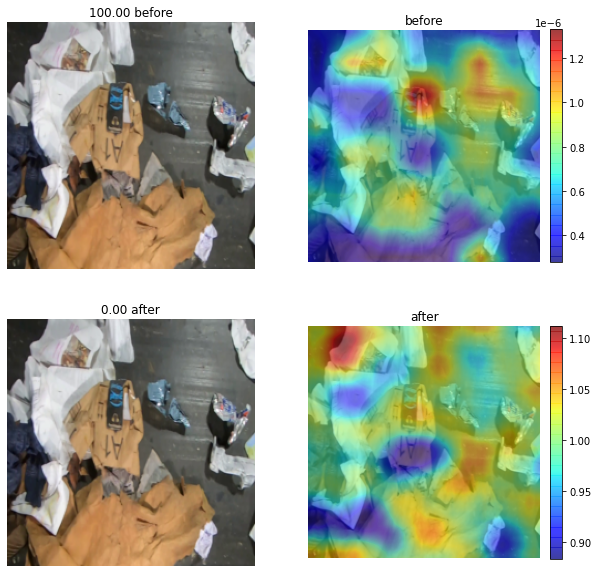

In [21]:
example(read_tensor(img_file), 2)